# Experiment 009

In this experiment, we try out a new architecture for the Tetris emulator model which incorporates global information as well as local information into the predictions.

In [1]:
import os
from pathlib import Path
import shutil
import datetime

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.data import Dataset
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

In [2]:
class RecordingDataset(Dataset):
    def __init__(self, path: str):
        self.path = path
        if not os.path.exists(path):
            raise FileNotFoundError()
        with os.scandir(self.path) as it:
            entry: os.DirEntry = next(iter(it))
            _, self.ext = os.path.splitext(entry.name)
            self.highest_index = max((int(Path(file.path).stem) for file in it), default=-1)

    def __len__(self):
        return self.highest_index + 1

    def __getitem__(self, idx):
        file = os.path.join(self.path, f"{idx}{self.ext}")
        if not os.path.exists(file):
            raise IndexError()
        boards = np.load(file)
        x = torch.tensor(boards[-2]) # Ignore all boards except the last two
        y = torch.tensor(boards[-1], dtype=torch.long)
        return x, y
        

In [3]:
train_dataset = RecordingDataset(os.path.join("data", "tetris_emulator", "train"))
test_dataset = RecordingDataset(os.path.join("data", "tetris_emulator", "test"))
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)

x, y = next(iter(train_dataloader))
print(x.shape, x.dtype)
print(y.shape, y.dtype)

torch.Size([4, 22, 10]) torch.int32
torch.Size([4, 22, 10]) torch.int64


In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [5]:
class TetrisModel(nn.Module):
    """Predicts the next state of the cells.

    Inputs:
        x: Tensor of int32 of shape (batch_size, height, width). height = 22 and width = 10 are the dimensions of the game
           board. The entries should be 0 for empty cells and 1 for blocks.
    
    Returns: Tensor of float32 of shape (batch_size, height, width), logits for the new cells. Probabilities close to 0 (negative logits)
             correspond to empty cells, and probabilities close to 1 (positive logits) correspond to blocks.
    """

    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(2, 10, 3, padding=1)
        self.conv1 = nn.Conv2d(10, 10, 3, padding=1)
        self.conv2 = nn.Conv2d(10, 10, 1)
        self.conv3 = nn.Conv2d(10, 2, 1)

    def forward(self, x):
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((0, 3, 1, 2)) # Move channels/classes to dimension 1
        x = F.relu(self.conv0(x))
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        logits = F.log_softmax(self.conv3(x), dim=1)
        return logits

In [10]:
class LocalGlobalModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.global_module = nn.Sequential(
            nn.Conv2d(2, 5, 3),               # (26, 14) -> (24, 12)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),      # (24, 12) -> (12,  6)
            nn.Conv2d(5, 10, 3),              # (12,  6) -> (10,  4)
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(6, 3)), # ( 6,  3) -> ( 1,  1)
        )
        self.local_module = nn.Sequential(
            nn.Conv2d(2, 5, 3),
            nn.ReLU(),
            nn.Conv2d(5, 10, 3),
            nn.ReLU(),
        )
        self.conv0 = nn.Conv2d(20, 10, 1)
        self.conv1 = nn.Conv2d(10, 2, 1)

    def forward(self, x):
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((0, 3, 1, 2)) # Move channels/classes to dimension 1
        x = F.pad(x, (2, 2, 2, 2)) # Zero-pad 2 cells on each side
        x_local = self.local_module(x) # Extract local information
        x_global = self.global_module(x) # Extract global information
        x_global = x_global.repeat(1, 1, 22, 10) # Broadcast global information to image dimensions
        x = torch.cat((x_local, x_global), dim=1) # Combine local and global information
        x = F.relu(self.conv0(x))
        logits = F.log_softmax(self.conv1(x), dim=1)
        return logits

In [11]:
model = LocalGlobalModel().to(device)
print(model)

X, y = next(iter(train_dataloader))
logits = model(X)[0]
preds = F.sigmoid(logits)
print(f"Predicted states: {preds}")

LocalGlobalModel(
  (global_module): Sequential(
    (0): Conv2d(2, 5, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=(6, 3), stride=(6, 3), padding=0)
  )
  (local_module): Sequential(
    (0): Conv2d(2, 5, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
  )
  (conv0): Conv2d(20, 10, kernel_size=(1, 1), stride=(1, 1))
  (conv1): Conv2d(10, 2, kernel_size=(1, 1), stride=(1, 1))
)
Predicted states: tensor([[[0.2740, 0.2753, 0.2754, 0.2754, 0.2754, 0.2754, 0.2754, 0.2754,
          0.2753, 0.2752],
         [0.2734, 0.2739, 0.2734, 0.2734, 0.2734, 0.2734, 0.2734, 0.2734,
          0.2736, 0.2743],
         [0.2739, 0.2745, 0.2741, 0.2741, 0.2741, 0.2741, 0.2741, 0.2741,
          0.2742, 0.2746],
         [0.2739, 0.2745, 

In [12]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()

    epoch_loss = 0.0
    cell_accuracy = 0.0
    board_accuracy = 0.0

    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        classes = torch.argmax(pred, dim=1)
        cell_accuracy += (classes == y).type(torch.float).mean().item()
        board_accuracy += (classes == y).all(-1).all(-1).type(torch.float).mean().item()

        if batch % 20 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    epoch_loss /= num_batches
    cell_accuracy /= num_batches
    board_accuracy /= num_batches
    return {
        "loss": epoch_loss,
        "acc": cell_accuracy,
        "acc_board": board_accuracy
    }


def test_loop(dataloader, model, loss_fn):
    model.eval()

    epoch_loss = 0.0
    cell_accuracy = 0.0
    board_accuracy = 0.0

    num_batches = len(dataloader)
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            epoch_loss += loss_fn(pred, y).item()
            classes = torch.argmax(pred, dim=1)
            cell_accuracy += (classes == y).type(torch.float).mean().item()
            board_accuracy += (classes == y).all(-1).all(-1).type(torch.float).mean().item()

    epoch_loss /= num_batches
    cell_accuracy /= num_batches
    board_accuracy /= num_batches
    print(f"Test Error: \n Accuracy: {(100*cell_accuracy):>0.1f}%, Board accuracy: {(100*board_accuracy):>0.1f}%, Avg loss: {epoch_loss:>8f} \n")
    return {
        "loss": epoch_loss,
        "acc": cell_accuracy,
        "acc_board": board_accuracy
    }

In [27]:
learning_rate = 1e-1
epochs = 100

models = {
    "baseline": TetrisModel().to(device),
    "local_global": LocalGlobalModel().to(device)
}

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

for name, model in models.items():
    print(f"Model '{name}' has {count_parameters(model)} parameters.")

log_dir = os.path.join("runs", "experiment_009")
# shutil.rmtree(log_dir, ignore_errors=True)

for name, model in models.items():
    loss_fn = nn.NLLLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    log_subdir = os.path.join(log_dir, name + "_" + datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
    tb = SummaryWriter(log_subdir)

    print(f"Training model {name}...")
    for t in range(epochs):
        print(f"Epoch {t}\n-------------------------------")
        train_metrics = train_loop(train_dataloader, model, loss_fn, optimizer)
        test_metrics = test_loop(test_dataloader, model, loss_fn)
        tb.add_scalar("Loss/train", train_metrics["loss"], t)
        tb.add_scalar("Cell accuracy/train", train_metrics["acc"], t)
        tb.add_scalar("Board accuracy/train", train_metrics["acc_board"], t)
        tb.add_scalar("Loss/test", test_metrics["loss"], t)
        tb.add_scalar("Cell accuracy/test", test_metrics["acc"], t)
        tb.add_scalar("Board accuracy/test", test_metrics["acc_board"], t)
        for name, weight in model.named_parameters():
            tb.add_histogram(f"Weights/{name}", weight, t)
            tb.add_histogram(f"Gradients/{name}", weight.grad, t)

    tb.close()
    print("Done!")

Model 'baseline' has 1232 parameters.
Model 'local_global' has 1342 parameters.
Training model baseline...
Epoch 0
-------------------------------
loss: 0.595740  [    4/  237]
loss: 0.293449  [   84/  237]
loss: 0.288356  [  164/  237]
Test Error: 
 Accuracy: 91.4%, Board accuracy: 0.0%, Avg loss: 0.288916 

Epoch 1
-------------------------------
loss: 0.260252  [    4/  237]
loss: 0.260029  [   84/  237]
loss: 0.272077  [  164/  237]
Test Error: 
 Accuracy: 91.3%, Board accuracy: 0.0%, Avg loss: 0.218866 

Epoch 2
-------------------------------
loss: 0.242478  [    4/  237]
loss: 0.118317  [   84/  237]
loss: 0.092602  [  164/  237]
Test Error: 
 Accuracy: 95.8%, Board accuracy: 0.0%, Avg loss: 0.106572 

Epoch 3
-------------------------------
loss: 0.106475  [    4/  237]
loss: 0.101227  [   84/  237]
loss: 0.132749  [  164/  237]
Test Error: 
 Accuracy: 96.4%, Board accuracy: 0.0%, Avg loss: 0.081486 

Epoch 4
-------------------------------
loss: 0.071601  [    4/  237]
loss: 0

In [25]:
def show_prediction(example):
    x, y = example
    with torch.no_grad():
        pred_baseline = models["baseline"](x.unsqueeze(0)).argmax(dim=1).squeeze(0)
        pred_local_global = models["local_global"](x.unsqueeze(0)).argmax(dim=1).squeeze(0)

    fig, axs = plt.subplots(1, 4)
    fig.suptitle("Prediction vs reality")

    for ax in axs:
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

    axs[0].set_title("Input")
    axs[1].set_title("Reality")
    axs[2].set_title("baseline")
    axs[3].set_title("local_global")

    axs[0].imshow(x)
    axs[1].imshow(y)
    axs[2].imshow(pred_baseline)
    axs[3].imshow(pred_local_global)

    plt.show()

Showing prediction for training example 167


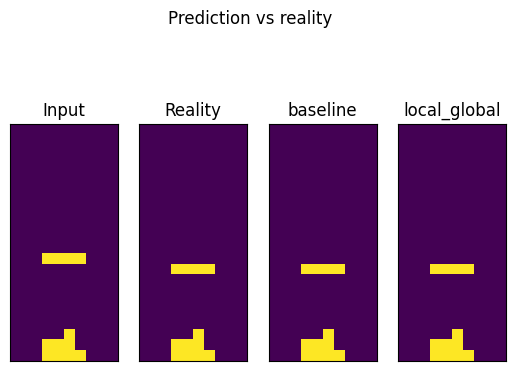

In [125]:
# Show a random training predictions vs reality
import random

idx = random.randrange(len(train_dataset))
print(f"Showing prediction for training example {idx}")
show_prediction(train_dataset[idx])

Showing prediction for test example 45


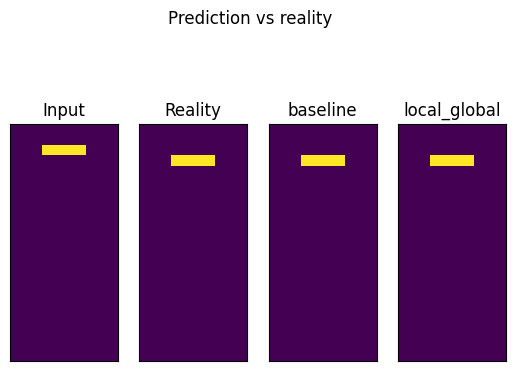

In [228]:
# Show a random test predictions vs reality
idx = random.randrange(len(test_dataset))
print(f"Showing prediction for test example {idx}")
show_prediction(test_dataset[idx])

Showing prediction for training example 96


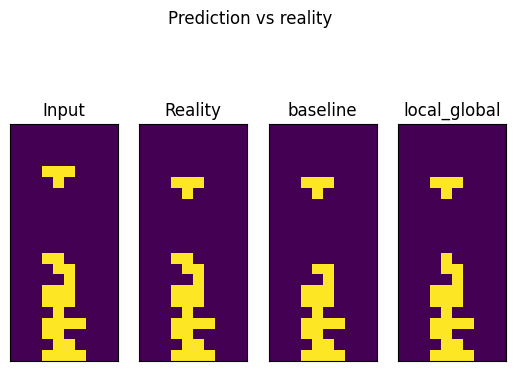

In [252]:
# Show a random training prediction where the baseline model failed
success = True
while success:
    idx = random.randrange(len(train_dataset))
    example = train_dataset[idx]
    x, y = example
    with torch.no_grad():
        pred = models["baseline"](x.unsqueeze(0)).squeeze(0).argmax(0)
        success = (pred == y).all(-1).all(-1).item()
print(f"Showing prediction for training example {idx}")
show_prediction(train_dataset[idx])

Showing prediction for training example 31


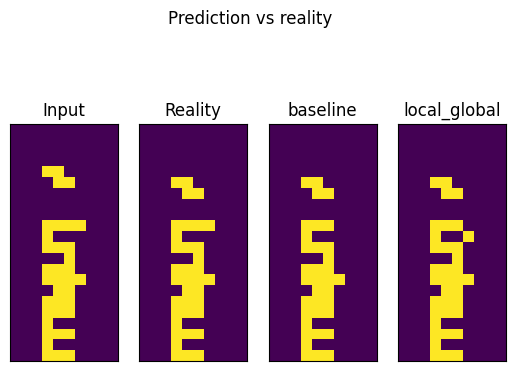

In [241]:
# Show a random training prediction where the local_global model failed
success = True
while success:
    idx = random.randrange(len(train_dataset))
    example = train_dataset[idx]
    x, y = example
    with torch.no_grad():
        pred = models["local_global"](x.unsqueeze(0)).squeeze(0).argmax(0)
        success = (pred == y).all(-1).all(-1).item()
print(f"Showing prediction for training example {idx}")
show_prediction(train_dataset[idx])

In [245]:
# Count the number of examples where each model failed
train_total = len(train_dataset)
train_bf_lf = 0
train_bf_ls = 0
train_bs_lf = 0
train_bs_ls = 0
for x, y in train_dataset:
    success_baseline = (models["baseline"](x.unsqueeze(0)).squeeze(0).argmax(0) == y).all(-1).all(-1).item()
    success_local_global = (models["local_global"](x.unsqueeze(0)).squeeze(0).argmax(0) == y).all(-1).all(-1).item()
    if success_baseline:
        if success_local_global:
            train_bs_ls += 1
        else:
            train_bs_lf += 1
    else:
        if success_local_global:
            train_bf_ls += 1
        else:
            train_bf_lf += 1

print("Training data:")
print(f"{train_total} examples in total.")
print(f"{train_bs_ls} examples where both succeeded.")
print(f"{train_bf_lf} examples where both failed.")
print(f"{train_bs_lf} examples where baseline succeeded and local_global failed.")
print(f"{train_bf_ls} examples where local_global succeeded and baseline failed.")
print()

test_total = len(test_dataset)
test_bf_lf = 0
test_bf_ls = 0
test_bs_lf = 0
test_bs_ls = 0
for x, y in test_dataset:
    success_baseline = (models["baseline"](x.unsqueeze(0)).squeeze(0).argmax(0) == y).all(-1).all(-1).item()
    success_local_global = (models["local_global"](x.unsqueeze(0)).squeeze(0).argmax(0) == y).all(-1).all(-1).item()
    if success_baseline:
        if success_local_global:
            test_bs_ls += 1
        else:
            test_bs_lf += 1
    else:
        if success_local_global:
            test_bf_ls += 1
        else:
            test_bf_lf += 1

print("Test data:")
print(f"{test_total} examples in total.")
print(f"{test_bs_ls} examples where both succeeded.")
print(f"{test_bf_lf} examples where both failed.")
print(f"{test_bs_lf} examples where baseline succeeded and local_global failed.")
print(f"{test_bf_ls} examples where local_global succeeded and baseline failed.")

Training data:
237 examples in total.
206 examples where both succeeded.
18 examples where both failed.
10 examples where baseline succeeded and local_global failed.
3 examples where local_global succeeded and baseline failed.

Test data:
59 examples in total.
50 examples where both succeeded.
6 examples where both failed.
3 examples where baseline succeeded and local_global failed.
0 examples where local_global succeeded and baseline failed.


The local_global model reaches about the same test board accuracy and slightly worse training board accuracy than the baseline model. In terms of loss, the test loss occasionally spikes up drastically in the baseline model during training, but only jumps up slightly in the local_global model.

By looking at a few random predictions, it seems both models do a fairly good job at prediction. The baseline model never manages to spawn a new block, but it makes few "local" mistakes. The local_global model makes some silly "local" mistakes, but does manage to spawn blocks occasionally. However, it tends to do so when an existing block is still falling.

One realisation I had during this experiment was that, to accurately simulate Tetris, we cannot just predict cell states based on thresholds, because that makes the predictions deterministic based on the state of the board, but we know that the choice of which block will drop next is nondeterministic. We'll have to figure out how to handle this.

Another observation is that we haven't really experienced overfitting in terms of the test loss going up, so we could try using a larger model and see if this improves the performance.

# Increasing capacity

Let's try using variants of the two models with much larger capacity to see if we can get better performance before they start overfitting.

In [260]:
def training_process(model_class, learning_rate, epochs):
    model = model_class().to(device)

    log_dir = os.path.join("runs", "experiment_009")

    loss_fn = nn.NLLLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    log_subdir = os.path.join(log_dir, f"{model_class.__name__}_lr_{str(learning_rate).replace('.', '_')}_ep_{epochs}_" + datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
    tb = SummaryWriter(log_subdir)

    print(f"Training...")
    for t in range(epochs):
        print(f"Epoch {t}\n-------------------------------")
        train_metrics = train_loop(train_dataloader, model, loss_fn, optimizer)
        test_metrics = test_loop(test_dataloader, model, loss_fn)
        tb.add_scalar("Loss/train", train_metrics["loss"], t)
        tb.add_scalar("Cell accuracy/train", train_metrics["acc"], t)
        tb.add_scalar("Board accuracy/train", train_metrics["acc_board"], t)
        tb.add_scalar("Loss/test", test_metrics["loss"], t)
        tb.add_scalar("Cell accuracy/test", test_metrics["acc"], t)
        tb.add_scalar("Board accuracy/test", test_metrics["acc_board"], t)
        for name, weight in model.named_parameters():
            tb.add_histogram(f"Weights/{name}", weight, t)
            tb.add_histogram(f"Gradients/{name}", weight.grad, t)

    tb.close()
    print("Done!")
    return model

In [263]:
class LG2(nn.Module):
    """Added extra 1x1 convs at the end, increasing the number of channels."""
    def __init__(self):
        super().__init__()
        self.global_module = nn.Sequential(
            nn.Conv2d(2, 5, 3),               # (26, 14) -> (24, 12)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),      # (24, 12) -> (12,  6)
            nn.Conv2d(5, 10, 3),              # (12,  6) -> (10,  4)
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(6, 3)), # ( 6,  3) -> ( 1,  1)
        )
        self.local_module = nn.Sequential(
            nn.Conv2d(2, 5, 3),
            nn.ReLU(),
            nn.Conv2d(5, 10, 3),
            nn.ReLU(),
        )
        self.conv0 = nn.Conv2d(20, 40, 1)
        self.conv1 = nn.Conv2d(40, 20, 1)
        self.conv2 = nn.Conv2d(20, 10, 1)
        self.conv3 = nn.Conv2d(10, 5, 1)
        self.conv4 = nn.Conv2d(5, 2, 1)

    def forward(self, x):
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((0, 3, 1, 2)) # Move channels/classes to dimension 1
        x = F.pad(x, (2, 2, 2, 2)) # Zero-pad 2 cells on each side
        x_local = self.local_module(x) # Extract local information
        x_global = self.global_module(x) # Extract global information
        x_global = x_global.repeat(1, 1, 22, 10) # Broadcast global information to image dimensions
        x = torch.cat((x_local, x_global), dim=1) # Combine local and global information
        x = F.relu(self.conv0(x))
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        logits = F.log_softmax(self.conv4(x), dim=1)
        return logits

In [264]:
training_process(LG2, 1e-1, 100)

Training...
Epoch 0
-------------------------------
loss: 0.650481  [    4/  237]
loss: 0.379707  [   84/  237]
loss: 0.269441  [  164/  237]
Test Error: 
 Accuracy: 91.3%, Board accuracy: 0.0%, Avg loss: 0.297920 

Epoch 1
-------------------------------
loss: 0.286257  [    4/  237]
loss: 0.294141  [   84/  237]
loss: 0.315266  [  164/  237]
Test Error: 
 Accuracy: 91.3%, Board accuracy: 0.0%, Avg loss: 0.295024 

Epoch 2
-------------------------------
loss: 0.262535  [    4/  237]
loss: 0.294042  [   84/  237]
loss: 0.262086  [  164/  237]
Test Error: 
 Accuracy: 91.3%, Board accuracy: 0.0%, Avg loss: 0.296148 

Epoch 3
-------------------------------
loss: 0.293988  [    4/  237]
loss: 0.194941  [   84/  237]
loss: 0.240317  [  164/  237]
Test Error: 
 Accuracy: 91.2%, Board accuracy: 0.0%, Avg loss: 0.297352 

Epoch 4
-------------------------------
loss: 0.315023  [    4/  237]
loss: 0.294207  [   84/  237]
loss: 0.229125  [  164/  237]
Test Error: 
 Accuracy: 91.3%, Board accur

LG2(
  (global_module): Sequential(
    (0): Conv2d(2, 5, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=(6, 3), stride=(6, 3), padding=0)
  )
  (local_module): Sequential(
    (0): Conv2d(2, 5, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
  )
  (conv0): Conv2d(20, 40, kernel_size=(1, 1), stride=(1, 1))
  (conv1): Conv2d(40, 20, kernel_size=(1, 1), stride=(1, 1))
  (conv2): Conv2d(20, 10, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(10, 5, kernel_size=(1, 1), stride=(1, 1))
  (conv4): Conv2d(5, 2, kernel_size=(1, 1), stride=(1, 1))
)

In [265]:
model = training_process(LG2, 1e-1, 300)

Training...
Epoch 0
-------------------------------
loss: 0.721277  [    4/  237]
loss: 0.401280  [   84/  237]
loss: 0.331926  [  164/  237]
Test Error: 
 Accuracy: 91.3%, Board accuracy: 0.0%, Avg loss: 0.306555 

Epoch 1
-------------------------------
loss: 0.271901  [    4/  237]
loss: 0.255345  [   84/  237]
loss: 0.259120  [  164/  237]
Test Error: 
 Accuracy: 91.2%, Board accuracy: 0.0%, Avg loss: 0.298143 

Epoch 2
-------------------------------
loss: 0.284993  [    4/  237]
loss: 0.223141  [   84/  237]
loss: 0.232225  [  164/  237]
Test Error: 
 Accuracy: 91.2%, Board accuracy: 0.0%, Avg loss: 0.297696 

Epoch 3
-------------------------------
loss: 0.273324  [    4/  237]
loss: 0.231532  [   84/  237]
loss: 0.262571  [  164/  237]
Test Error: 
 Accuracy: 91.3%, Board accuracy: 0.0%, Avg loss: 0.294780 

Epoch 4
-------------------------------
loss: 0.283393  [    4/  237]
loss: 0.250893  [   84/  237]
loss: 0.272659  [  164/  237]
Test Error: 
 Accuracy: 91.2%, Board accur

LG2(
  (global_module): Sequential(
    (0): Conv2d(2, 5, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=(6, 3), stride=(6, 3), padding=0)
  )
  (local_module): Sequential(
    (0): Conv2d(2, 5, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
  )
  (conv0): Conv2d(20, 40, kernel_size=(1, 1), stride=(1, 1))
  (conv1): Conv2d(40, 20, kernel_size=(1, 1), stride=(1, 1))
  (conv2): Conv2d(20, 10, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(10, 5, kernel_size=(1, 1), stride=(1, 1))
  (conv4): Conv2d(5, 2, kernel_size=(1, 1), stride=(1, 1))
)

Looks like the larger model has a lot more loss and accuracy spikes during training, but seems to achieving a higher accuracy.

In [267]:
def show_random_prediction(model):
    idx = random.randrange(len(train_dataset))
    print(f"Showing prediction for training example {idx}")
    example = train_dataset[idx]

    x, y = example
    with torch.no_grad():
        pred = model(x.unsqueeze(0)).argmax(dim=1).squeeze(0)

    fig, axs = plt.subplots(1, 3)
    fig.suptitle("Prediction vs reality")

    for ax in axs:
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

    axs[0].set_title("Input")
    axs[1].set_title("Reality")
    axs[2].set_title("Predicted")

    axs[0].imshow(x)
    axs[1].imshow(y)
    axs[2].imshow(pred)

    plt.show()

Showing prediction for training example 34


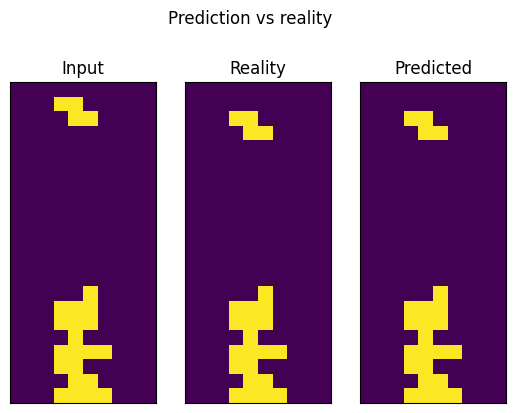

In [282]:
show_random_prediction(model)

In [285]:
def show_random_failed_prediction(model):
    success = True
    with torch.no_grad():
        while success:
            idx = random.randrange(len(train_dataset))
            x, y = train_dataset[idx]
            pred = model(x.unsqueeze(0)).squeeze(0).argmax(0)
            success = (pred == y).all(-1).all(-1).item()

    print(f"Showing prediction for training example {idx}")
    fig, axs = plt.subplots(1, 3)
    fig.suptitle("Prediction vs reality")

    for ax in axs:
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

    axs[0].set_title("Input")
    axs[1].set_title("Reality")
    axs[2].set_title("Predicted")

    axs[0].imshow(x)
    axs[1].imshow(y)
    axs[2].imshow(pred)

    plt.show()

Showing prediction for training example 234


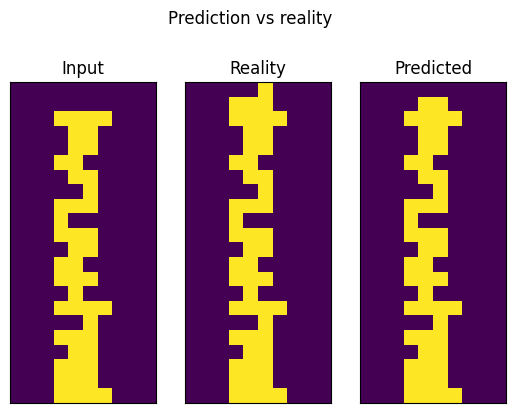

In [301]:
show_random_failed_prediction(model)

In [296]:
class LG3(nn.Module):
    """Like LG2, but with more channels in the local and global modules."""
    def __init__(self):
        super().__init__()
        self.global_module = nn.Sequential(
            nn.Conv2d(2, 20, 3),               # (26, 14) -> (24, 12)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),      # (24, 12) -> (12,  6)
            nn.Conv2d(20, 40, 3),              # (12,  6) -> (10,  4)
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(6, 3)), # ( 6,  3) -> ( 1,  1)
        )
        self.local_module = nn.Sequential(
            nn.Conv2d(2, 20, 3),
            nn.ReLU(),
            nn.Conv2d(20, 40, 3),
            nn.ReLU(),
        )
        self.conv0 = nn.Conv2d(80, 80, 1)
        self.conv1 = nn.Conv2d(80, 40, 1)
        self.conv2 = nn.Conv2d(40, 20, 1)
        self.conv3 = nn.Conv2d(20, 10, 1)
        self.conv4 = nn.Conv2d(10, 2, 1)

    def forward(self, x):
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((0, 3, 1, 2)) # Move channels/classes to dimension 1
        x = F.pad(x, (2, 2, 2, 2)) # Zero-pad 2 cells on each side
        x_local = self.local_module(x) # Extract local information
        x_global = self.global_module(x) # Extract global information
        x_global = x_global.repeat(1, 1, 22, 10) # Broadcast global information to image dimensions
        x = torch.cat((x_local, x_global), dim=1) # Combine local and global information
        x = F.relu(self.conv0(x))
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        logits = F.log_softmax(self.conv4(x), dim=1)
        return logits

In [302]:
model = training_process(LG3, 1e-1, 300)

Training...
Epoch 0
-------------------------------
loss: 0.783855  [    4/  237]
loss: 0.313248  [   84/  237]
loss: 0.226637  [  164/  237]
Test Error: 
 Accuracy: 91.2%, Board accuracy: 0.0%, Avg loss: 0.297671 

Epoch 1
-------------------------------
loss: 0.314827  [    4/  237]
loss: 0.325039  [   84/  237]
loss: 0.314699  [  164/  237]
Test Error: 
 Accuracy: 91.3%, Board accuracy: 0.0%, Avg loss: 0.294697 

Epoch 2
-------------------------------
loss: 0.315461  [    4/  237]
loss: 0.304429  [   84/  237]
loss: 0.293592  [  164/  237]
Test Error: 
 Accuracy: 91.3%, Board accuracy: 0.0%, Avg loss: 0.294746 

Epoch 3
-------------------------------
loss: 0.293543  [    4/  237]
loss: 0.261682  [   84/  237]
loss: 0.239204  [  164/  237]
Test Error: 
 Accuracy: 91.3%, Board accuracy: 0.0%, Avg loss: 0.294718 

Epoch 4
-------------------------------
loss: 0.198530  [    4/  237]
loss: 0.271698  [   84/  237]
loss: 0.368152  [  164/  237]
Test Error: 
 Accuracy: 91.3%, Board accur

Showing prediction for training example 24


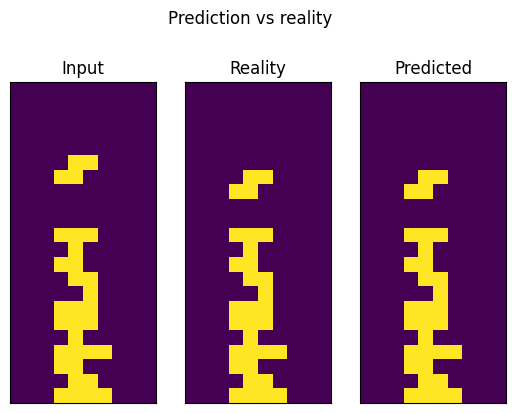

In [314]:
show_random_prediction(model)

Showing prediction for training example 217


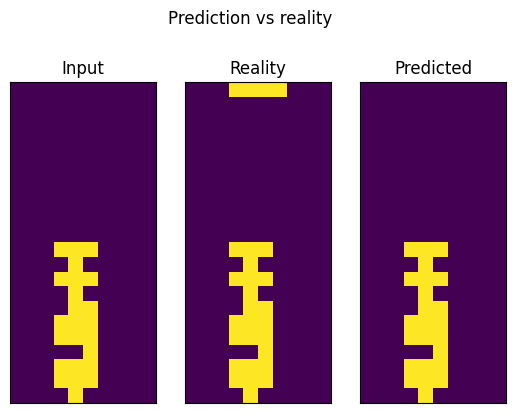

In [335]:
show_random_failed_prediction(model)

In [336]:
class LG4(nn.Module):
    """Like LG3, but with global max pool instead of average pool."""
    def __init__(self):
        super().__init__()
        self.global_module = nn.Sequential(
            nn.Conv2d(2, 20, 3),               # (26, 14) -> (24, 12)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),      # (24, 12) -> (12,  6)
            nn.Conv2d(20, 40, 3),              # (12,  6) -> (10,  4)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(6, 3)), # ( 6,  3) -> ( 1,  1)
        )
        self.local_module = nn.Sequential(
            nn.Conv2d(2, 20, 3),
            nn.ReLU(),
            nn.Conv2d(20, 40, 3),
            nn.ReLU(),
        )
        self.conv0 = nn.Conv2d(80, 80, 1)
        self.conv1 = nn.Conv2d(80, 40, 1)
        self.conv2 = nn.Conv2d(40, 20, 1)
        self.conv3 = nn.Conv2d(20, 10, 1)
        self.conv4 = nn.Conv2d(10, 2, 1)

    def forward(self, x):
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((0, 3, 1, 2)) # Move channels/classes to dimension 1
        x = F.pad(x, (2, 2, 2, 2)) # Zero-pad 2 cells on each side
        x_local = self.local_module(x) # Extract local information
        x_global = self.global_module(x) # Extract global information
        x_global = x_global.repeat(1, 1, 22, 10) # Broadcast global information to image dimensions
        x = torch.cat((x_local, x_global), dim=1) # Combine local and global information
        x = F.relu(self.conv0(x))
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        logits = F.log_softmax(self.conv4(x), dim=1)
        return logits

In [337]:
model = training_process(LG4, 1e-1, 300)

Training...
Epoch 0
-------------------------------
loss: 0.696731  [    4/  237]
loss: 0.358483  [   84/  237]
loss: 0.250700  [  164/  237]
Test Error: 
 Accuracy: 91.2%, Board accuracy: 0.0%, Avg loss: 0.306244 

Epoch 1
-------------------------------
loss: 0.337233  [    4/  237]
loss: 0.278220  [   84/  237]
loss: 0.224228  [  164/  237]
Test Error: 
 Accuracy: 91.2%, Board accuracy: 0.0%, Avg loss: 0.297443 

Epoch 2
-------------------------------
loss: 0.190770  [    4/  237]
loss: 0.230958  [   84/  237]
loss: 0.272729  [  164/  237]
Test Error: 
 Accuracy: 91.3%, Board accuracy: 0.0%, Avg loss: 0.295333 

Epoch 3
-------------------------------
loss: 0.293928  [    4/  237]
loss: 0.325800  [   84/  237]
loss: 0.272490  [  164/  237]
Test Error: 
 Accuracy: 91.2%, Board accuracy: 0.0%, Avg loss: 0.298131 

Epoch 4
-------------------------------
loss: 0.272494  [    4/  237]
loss: 0.208709  [   84/  237]
loss: 0.315250  [  164/  237]
Test Error: 
 Accuracy: 91.2%, Board accur

Showing prediction for training example 54


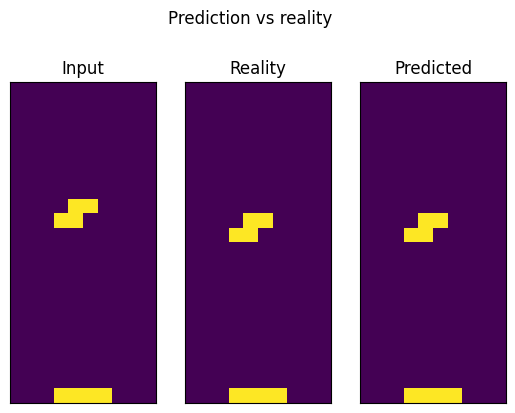

In [338]:
show_random_prediction(model)

Showing prediction for training example 94


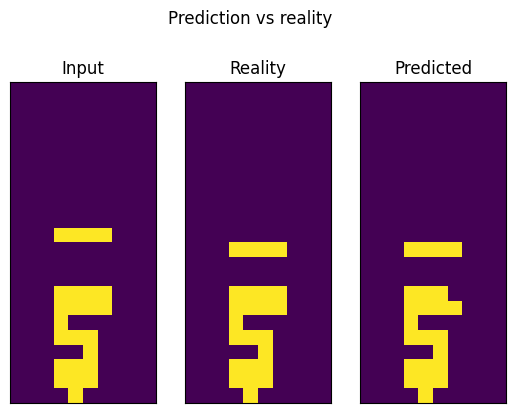

In [339]:
show_random_failed_prediction(model)

In [340]:
class FCModel(nn.Module):
    """What if instead of separating local and global at the start, we just fully connect the cells?"""
    def __init__(self):
        super().__init__()
        self.lin0 = nn.Linear(220, 1000)
        self.lin1 = nn.Linear(1000, 1000)
        self.lin2 = nn.Linear(1000, 440)

    def forward(self, x):
        x = x.type(torch.float)
        x = torch.flatten(x, 1)
        x = F.relu(self.lin0(x))
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        x = torch.reshape(x, (-1, 2, 22, 10))
        logits = F.log_softmax(x, dim=1)
        return logits

In [342]:
model = training_process(FCModel, 1e-1, 1000)

Training...
Epoch 0
-------------------------------
loss: 0.691422  [    4/  237]
loss: 0.676783  [   84/  237]
loss: 0.656854  [  164/  237]
Test Error: 
 Accuracy: 90.6%, Board accuracy: 0.0%, Avg loss: 0.637670 

Epoch 1
-------------------------------
loss: 0.644383  [    4/  237]
loss: 0.579736  [   84/  237]
loss: 0.516426  [  164/  237]
Test Error: 
 Accuracy: 92.3%, Board accuracy: 0.0%, Avg loss: 0.462079 

Epoch 2
-------------------------------
loss: 0.471453  [    4/  237]
loss: 0.313942  [   84/  237]
loss: 0.279169  [  164/  237]
Test Error: 
 Accuracy: 92.3%, Board accuracy: 0.0%, Avg loss: 0.273585 

Epoch 3
-------------------------------
loss: 0.362968  [    4/  237]
loss: 0.298757  [   84/  237]
loss: 0.199109  [  164/  237]
Test Error: 
 Accuracy: 92.5%, Board accuracy: 0.0%, Avg loss: 0.227303 

Epoch 4
-------------------------------
loss: 0.173378  [    4/  237]
loss: 0.156239  [   84/  237]
loss: 0.193567  [  164/  237]
Test Error: 
 Accuracy: 92.6%, Board accur

OK, using a fully connected model was a bit mad, but it does learn. The board accuracy increases much more like a straight line, where the convolution-based models' curves shoot up at the start and then level off quickly. Unfortunately, the fully connected model's test accuracy increases much more slowly than its training accuracy. After 1000 iterations, the fully connected model's training accuracy is 97%, higher than any of the convolution-based models' training accuracy, but its test accuracy levels off at 22% at 700 iterations and doesn't increase between 700 and 1000 iterations.

Showing prediction for training example 90


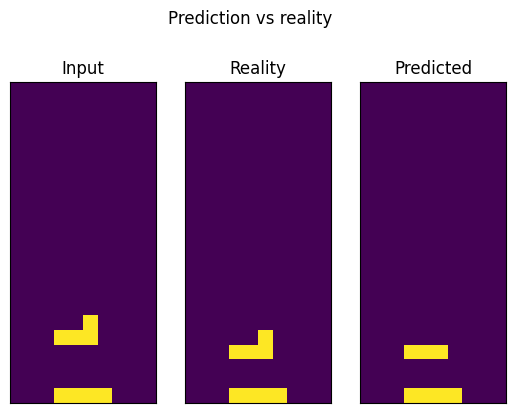

In [358]:
show_random_failed_prediction(model)

The failed predictions of this model show it is clearly lacking some geometric intuition.

In [363]:
class SkipConnectionModel(nn.Module):
    """Like the baseline, but with a skip connection from the input to the output, because we expect most cells not to change from one frame to the next."""
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(2, 10, 3, padding=1)
        self.conv1 = nn.Conv2d(10, 10, 3, padding=1)
        self.conv2 = nn.Conv2d(10, 10, 1)
        self.conv3 = nn.Conv2d(10, 2, 1)

    def forward(self, x):
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((0, 3, 1, 2)) # Move channels/classes to dimension 1
        x_skip = x # Store value of x for skip connection
        x = F.relu(self.conv0(x))
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        x = x + (x_skip - 0.5) * 20.0 # Add skip connection value that moves log_softmax close to the correct values
        logits = F.log_softmax(x, dim=1)
        return logits

In [362]:
model = training_process(SkipConnectionModel, 1e-1, 300)

Training...
Epoch 0
-------------------------------
loss: 0.545671  [    4/  237]
loss: 0.545582  [   84/  237]
loss: 0.590647  [  164/  237]
Test Error: 
 Accuracy: 97.1%, Board accuracy: 0.0%, Avg loss: 0.575548 

Epoch 1
-------------------------------
loss: 0.499696  [    4/  237]
loss: 0.499477  [   84/  237]
loss: 0.589608  [  164/  237]
Test Error: 
 Accuracy: 97.1%, Board accuracy: 0.0%, Avg loss: 0.572819 

Epoch 2
-------------------------------
loss: 0.544238  [    4/  237]
loss: 0.498709  [   84/  237]
loss: 0.589145  [  164/  237]
Test Error: 
 Accuracy: 97.1%, Board accuracy: 0.0%, Avg loss: 0.573064 

Epoch 3
-------------------------------
loss: 0.453277  [    4/  237]
loss: 0.498149  [   84/  237]
loss: 0.587910  [  164/  237]
Test Error: 
 Accuracy: 97.1%, Board accuracy: 0.0%, Avg loss: 0.573135 

Epoch 4
-------------------------------
loss: 0.497340  [    4/  237]
loss: 0.498768  [   84/  237]
loss: 0.542357  [  164/  237]
Test Error: 
 Accuracy: 97.1%, Board accur

It's unclear whether this skip connection helps a lot. On one of two tries, one train/test board accuracy curve was worse than the baseline and the test curve was very spiky; on the other try, the curves were better in that they shot up more steeply, but they still attained the same eventual upper bound.

In [364]:
class LG4WithSkip(nn.Module):
    """Like LG4, but with skip connection."""
    def __init__(self):
        super().__init__()
        self.global_module = nn.Sequential(
            nn.Conv2d(2, 20, 3),               # (26, 14) -> (24, 12)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),      # (24, 12) -> (12,  6)
            nn.Conv2d(20, 40, 3),              # (12,  6) -> (10,  4)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(6, 3)), # ( 6,  3) -> ( 1,  1)
        )
        self.local_module = nn.Sequential(
            nn.Conv2d(2, 20, 3),
            nn.ReLU(),
            nn.Conv2d(20, 40, 3),
            nn.ReLU(),
        )
        self.conv0 = nn.Conv2d(80, 80, 1)
        self.conv1 = nn.Conv2d(80, 40, 1)
        self.conv2 = nn.Conv2d(40, 20, 1)
        self.conv3 = nn.Conv2d(20, 10, 1)
        self.conv4 = nn.Conv2d(10, 2, 1)

    def forward(self, x):
        x = F.one_hot(x.long(), 2) # One-hot encode the two cell classes
        x = x.type(torch.float) # Convert to floating-point
        x = x.permute((0, 3, 1, 2)) # Move channels/classes to dimension 1
        x_skip = x
        x = F.pad(x, (2, 2, 2, 2)) # Zero-pad 2 cells on each side
        x_local = self.local_module(x) # Extract local information
        x_global = self.global_module(x) # Extract global information
        x_global = x_global.repeat(1, 1, 22, 10) # Broadcast global information to image dimensions
        x = torch.cat((x_local, x_global), dim=1) # Combine local and global information
        x = F.relu(self.conv0(x))
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        x = x + (x_skip - 0.5) * 20.0
        logits = F.log_softmax(x, dim=1)
        return logits

In [365]:
model = training_process(LG4WithSkip, 1e-1, 300)

Training...
Epoch 0
-------------------------------
loss: 0.500000  [    4/  237]
loss: 0.456132  [   84/  237]
loss: 0.590907  [  164/  237]
Test Error: 
 Accuracy: 97.1%, Board accuracy: 0.0%, Avg loss: 0.575300 

Epoch 1
-------------------------------
loss: 0.500000  [    4/  237]
loss: 0.590906  [   84/  237]
loss: 0.636362  [  164/  237]
Test Error: 
 Accuracy: 97.1%, Board accuracy: 0.0%, Avg loss: 0.576260 

Epoch 2
-------------------------------
loss: 0.590907  [    4/  237]
loss: 0.499996  [   84/  237]
loss: 0.545455  [  164/  237]
Test Error: 
 Accuracy: 97.1%, Board accuracy: 0.0%, Avg loss: 0.578265 

Epoch 3
-------------------------------
loss: 0.499997  [    4/  237]
loss: 0.545451  [   84/  237]
loss: 0.499997  [  164/  237]
Test Error: 
 Accuracy: 97.1%, Board accuracy: 0.0%, Avg loss: 0.576229 

Epoch 4
-------------------------------
loss: 0.545452  [    4/  237]
loss: 0.545451  [   84/  237]
loss: 0.499999  [  164/  237]
Test Error: 
 Accuracy: 97.1%, Board accur